In [2]:
import pandas as pd 
import numpy as np

import os
import glob 

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt

import seaborn as sns

from scipy.interpolate import interp2d
from scipy.interpolate import LinearNDInterpolator

In [3]:
df_prodHist = pd.read_csv("production_history.csv")

df_preProc = pd.read_csv("wellbore_data_preproduction_well.csv")
df_producer = pd.read_csv("producer_imputedData.csv")      #This is the training data

#Horizon/Formation data 
AI = np.load("2d_ai.npy")
sandFraction = np.load("2d_sand_propotion.npy")
sandyShaleFraction = np.load("2d_sandy_shale_propotion.npy")
shaleFraction = np.load("2d_shale_propotion.npy")
shalySandFraction = np.load("2d_shaly_sand_propotion.npy")
topDepth = np.load("2d_top_depth.npy")

#Merge data of two tables 
df_producer_hist = df_producer.merge(df_prodHist, how = 'inner', on = 'Well_ID')

In [4]:
df_producer

,Unnamed: 0,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa",Vclay
0,0,Well_no_1,7325,7175,3052.80,0.13330,87.062857,6.981172e+06,Sandstone,2.280137,3106.544655,24.721555,1690.417133,7.304717,0.0
1,1,Well_no_1,7325,7175,3053.30,0.13865,96.932947,7.234749e+06,Sandstone,2.135061,4003.697087,23.360728,1573.847967,5.202120,0.0
2,2,Well_no_1,7325,7175,3053.80,0.14638,124.117147,7.157384e+06,Sandstone,1.991045,3462.569030,28.232152,1636.279139,5.330842,0.0
3,3,Well_no_1,7325,7175,3054.30,NaN,NaN,7.182960e+06,Sandstone,1.694242,3836.960702,29.220132,1613.043048,5.074763,0.0
4,4,Well_no_1,7325,7175,3054.80,0.14993,130.423746,7.160059e+06,Sandstone,1.664371,3919.585777,25.569990,1636.846284,5.277834,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,175,Well_no_9,5625,5475,3053.55,0.13669,85.108425,7.265808e+06,Sandstone,2.117171,3560.915899,28.373557,1694.866606,6.081728,0.0
1444,176,Well_no_9,5625,5475,3054.05,0.15113,81.709799,7.243361e+06,Sandstone,1.676278,4327.923743,31.398236,1630.441892,4.622148,0.0
1445,177,Well_no_9,5625,5475,3054.55,0.14803,125.820159,6.945198e+06,Sandstone,1.510030,4571.841512,32.428499,1585.198861,5.343468,0.0
1446,178,Well_no_9,5625,5475,3055.05,0.15546,163.644772,7.090437e+06,Sandstone,1.623214,4125.621292,27.628327,1624.245258,5.214219,0.0


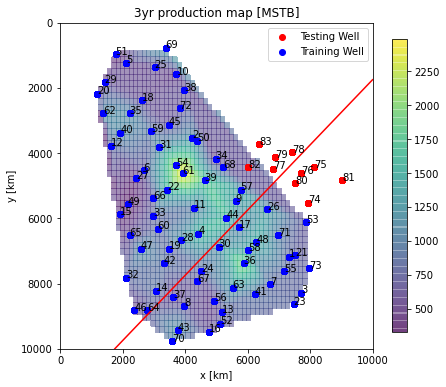

In [5]:
## Interpolating production data 
X_prod3 = df_producer_hist['X, m']
Y_prod3 = df_producer_hist['Y, m']
Z_prod3 = df_producer_hist['Cumulative oil production (3 yr), MSTB']

X_prod3 = np.linspace(min(df_producer_hist['X, m']), max(df_producer_hist['X, m']))
Y_prod3 = np.linspace(min(df_producer_hist['Y, m']), max(df_producer_hist['Y, m']))
X_prod3, Y_prod3 = np.meshgrid(X_prod3, Y_prod3) 
interp = LinearNDInterpolator(list(zip(df_producer_hist['X, m'], df_producer_hist['Y, m'])), df_producer_hist['Cumulative oil production (3 yr), MSTB'])
Z_prod3 = interp(X_prod3, Y_prod3)

fig, ax = plt.subplots(figsize = (7, 6))
im0 = ax.pcolormesh(X_prod3, Y_prod3, Z_prod3, shading='auto', alpha = 0.5) 
ax.plot([10000, 1750], [1750, 10000], 'r')
im1 = ax.scatter(df_preProc['X, m'], df_preProc['Y, m'], c = 'red')
im2 = ax.scatter(df_producer['X, m'], df_producer['Y, m'], c = 'blue')

#Plotting Well Number
for i in range(df_producer.groupby("Well_ID").mean().shape[0]):
    txt = df_producer.groupby("Well_ID").mean().reset_index().iloc[i, 0].split("_")[-1]
    ax.annotate(txt, ((df_producer.groupby("Well_ID").mean().reset_index().iloc[i]["X, m"], df_producer.groupby("Well_ID").mean().reset_index().iloc[i]["Y, m"])))

for i in range(df_preProc.groupby("Well_ID").mean().shape[0]):
    txt = df_preProc.groupby("Well_ID").mean().reset_index().iloc[i, 0].split("_")[-1]
    ax.annotate(txt, ((df_preProc.groupby("Well_ID").mean().reset_index().iloc[i]["X, m"], df_preProc.groupby("Well_ID").mean().reset_index().iloc[i]["Y, m"])))


ax.set_xlim([0, 10000])
ax.set_ylim([0, 10000])
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('3yr production map [MSTB]')
ax.legend([im1, im2], ['Testing Well', 'Training Well'])

fig.colorbar(im0, ax = ax, shrink=0.9)
plt.gca().invert_yaxis()


In [6]:
from sklearn.model_selection import train_test_split
X_data = df_producer_hist.groupby("Well_ID").agg("mean")
y_target = df_producer_hist.groupby("Well_ID").agg("mean")["Cumulative oil production (3 yr), MSTB"]
train, test, target, target_test = train_test_split(X_data, y_target, test_size=0.2, random_state=0)

interp = LinearNDInterpolator(list(zip(train['X, m'], train['Y, m'])), train['Cumulative oil production (3 yr), MSTB'])

error = []
errorPercent = []
for i in range(test.shape[0]):
    Z_prediction = interp(test['X, m'][i], test['Y, m'][i])
    print("True value: {}   Predicted value: {}".format(target_test[i], Z_prediction))
    error.append(np.abs(Z_prediction - target_test[i]))
    errorPercent.append(np.abs(Z_prediction - target_test[i])/target_test[i] * 100)

True value: 2124.8   Predicted value: 2112.4340375586853
True value: 1372.2000000000005   Predicted value: 1620.2983177570093
True value: 781.3999999999997   Predicted value: nan
True value: 307.11999999999995   Predicted value: 430.5343646408841
True value: 1122.1   Predicted value: 896.769273422562
True value: 780.1200000000003   Predicted value: 736.2476923076924
True value: 749.3999999999997   Predicted value: nan
True value: 835.5   Predicted value: 836.3342857142858
True value: 1098.1   Predicted value: 952.5018938053095
True value: 608.09   Predicted value: nan
True value: 1500.0   Predicted value: 1338.7959813084112
True value: 668.0200000000002   Predicted value: 685.0465979381446
True value: 470.12000000000006   Predicted value: nan
True value: 723.75   Predicted value: nan
True value: 1573.2000000000005   Predicted value: 1140.65546875


In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

X = np.array(list(zip(train['X, m'], train['Y, m'])))
y = train['Cumulative oil production (3 yr), MSTB'].values

kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
gp = GP(kernel = kernel, random_state = 0)


gp.fit(np.array(X), y)

print(np.array(X).shape)
print(y.shape)

(58, 2)
(58,)


In [8]:
gp.predict(np.array(list(zip(test['X, m'].values, test['Y, m'].values))).astype('float'))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [9]:
gp.predict(X)

array([1320.1 ,  492.86,  683.92,  812.2 , 1345.3 ,  375.02,  679.5 ,
        823.89,  732.29,  942.01,  704.82,  978.14, 1314.4 , 1095.3 ,
       1201.2 ,  539.98,  840.47, 1287.  ,  817.74,  643.14,  597.24,
        509.18,  702.16, 1801.8 , 1611.3 , 1136.3 ,  424.22, 2013.2 ,
       2514.5 ,  903.36, 1324.9 ,  847.33,  817.24,  897.16,  796.17,
       1209.6 ,  998.59, 1062.1 ,  751.92,  819.49, 1204.3 ,  578.87,
       1185.4 ,  365.32, 1194.2 ,  618.01, 1666.8 ,  518.27, 1146.  ,
        346.96,  905.74,  622.47,  597.31,  647.54, 1022.1 ,  636.83,
        805.49,  548.68])

C:\Users\ki2844\AppData\Local\Continuum\anaconda3\envs\datathon\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
<ipython-input-8-4e5030435735>:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X0p, X1p, Zp)


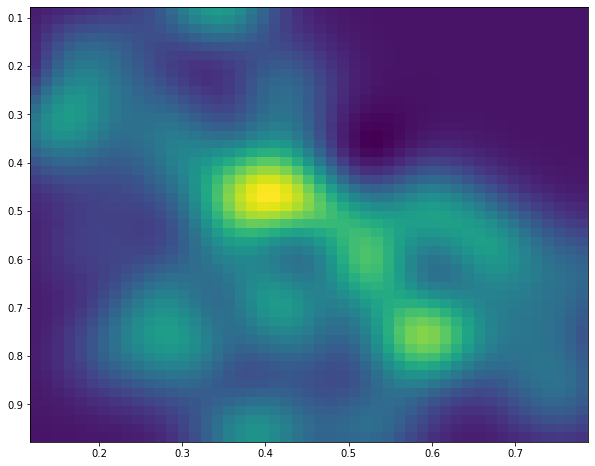

In [8]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Input space
X = np.array(list(zip(train['X, m'], train['Y, m'])))
X = X/10000
x1 = np.linspace(X[:,0].min(), X[:,0].max()) #p
x2 = np.linspace(X[:,1].min(), X[:,1].max()) #q
x = (np.array([x1, x2])).T

kernel = C(1.0, (1e-3, 1e3)) * RBF([2,2], (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

gp.fit(X, y)

x1x2 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2, return_std=True)

X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50)
Zp = np.reshape(y_pred,(50,50))

# alternative way to generate equivalent X0p, X1p, Zp
# X0p, X1p = np.meshgrid(x1, x2)
# Zp = [gp.predict([(X0p[i, j], X1p[i, j]) for i in range(X0p.shape[0])]) for j in range(X0p.shape[1])]
# Zp = np.array(Zp).T

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.pcolormesh(X0p, X1p, Zp)
plt.gca().invert_yaxis()

plt.show()

<ipython-input-52-a9f3867e22c0>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X0p, X1p, Zp)


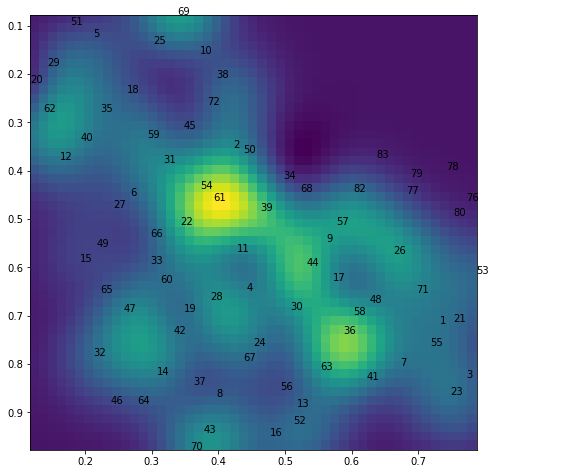

In [52]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.pcolormesh(X0p, X1p, Zp)
plt.gca().invert_yaxis()

#Plotting Well Number
for i in range(df_producer.groupby("Well_ID").mean().shape[0]):
    txt = df_producer.groupby("Well_ID").mean().reset_index().iloc[i, 0].split("_")[-1]
    ax.annotate(txt, ((df_producer.groupby("Well_ID").mean().reset_index().iloc[i]["X, m"]/10000, df_producer.groupby("Well_ID").mean().reset_index().iloc[i]["Y, m"]/10000)))

for i in range(df_preProc.groupby("Well_ID").mean().shape[0]):
    txt = df_preProc.groupby("Well_ID").mean().reset_index().iloc[i, 0].split("_")[-1]
    ax.annotate(txt, ((df_preProc.groupby("Well_ID").mean().reset_index().iloc[i]["X, m"]/10000, df_preProc.groupby("Well_ID").mean().reset_index().iloc[i]["Y, m"]/10000)))

plt.show()

In [10]:
gp.predict(np.array(list(zip(test['X, m'].values, test['Y, m'].values))).astype('float') / 10000)

array([2292.33704233, 1565.0494425 ,  685.69404744,  382.78255904,
        869.77333823,  718.42254565,  365.15216462,  881.56475698,
        952.39558414,  737.32499546, 1124.10730745,  640.40155526,
        360.73805903,  496.76046497, 1024.25423772])

In [11]:
np.mean(np.abs(target_test - gp.predict(np.array(list(zip(test['X, m'].values, test['Y, m'].values))).astype('float') / 10000)))

189.32396611884238